<a href="https://colab.research.google.com/github/DanielAlonsoCuriel/deeplearning/blob/main/LAB01_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import pandas as pd
host = 'raw.github.com'
user = 'fivethirtyeight'
repo = 'data'
branch = 'master'
file = 'births/US_births_2000-2014_SSA.csv'
url = f'https://{host}/{user}/{repo}/{branch}/{file}'
df = pd.read_csv(url,sep=',',header=0)
df.head()

# Practica 1 - Laboratorio 1
### Hecho por: Daniel Alonso, Alvaro García Cid, Enrique Ramos e Ignacio Regidor

##Resumen
En está práctica se estudiará una base de datos de Airbnb con información de diversos apartamentos de la ciudad de Nueva York, alquilados durante los últimos años.

A partir de estos datos, se realizará una clasificación en cuanto a popularidad, que dependerá de las reseñas por mes y la disponibilidad.

A continuación, de esta clasificiación se obtendrán  los más populares, para estudiarlos de forma gráfica (diagramas).

Esto, se realizará de forma similar diferenciando si el alquiler es de una habitación o del apartamento entero; y la manera en la que puede afectar esto.

Finalmente, se evaluará también de forma gráfica la tendencia al aumento de reseñas durante los últimos años.

##Introducción al problema y pasos previos
A continuación se muestrán las librerías de Python utilizadas en esta práctica.
- Numpy: utilizada por el resto de liberías, permite la creación y el manejo de datos de forma rápida y eficiente, conteniendo estructuras de datos propias.
- Pandas: permite la creación y manejo de dataframes a partir de la base de datos empleada.
- Matplotlib.pyplot: se utilizará para graficar los distintos diagramas que permitan el estudio de los datos de forma visual.

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##Preprocesamiento de los datos

Se procede a importar la base de datos contenida en un archivo .csv

Se guarda en una variable <i>dataframe</i> creada con la librería pandas a la que se le llamará "datosraw".

También se muestran 5 apartamentos de este dataframe con la función .head() para observar los nombres y tipos de sus distintos atributos.

In [104]:
datosraw = pd.read_csv("airbnb.csv", encoding='latin-1', sep=',')
datosraw.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


A continuación, con la función .shape, se obtiene que la base de datos contiene 48895 apartamentos, cada uno con 16 atributos diferentes.

In [105]:
datosraw.shape

(48895, 16)

En el siguiente paso, se buscan valores duplicados para su posterior eliminación.

Sin embargo, con la función duplicated() aplicada a cada columna del dataframe, obervamos que ninguna coincide en el atributo "id".

Esto, quiere decir que no hay apartamentos exactamente iguales que aparezcan más de una vez; y que este atributo es la clave primaria de los apartamentos, es decir, el identificador que los distingue de los demás.

In [106]:
for c in datosraw.columns:
  print("Duplicated Values [{0}]:".format(c), datosraw[c].duplicated().sum())

Duplicated Values [id]: 0
Duplicated Values [name]: 989
Duplicated Values [host_id]: 11438
Duplicated Values [host_name]: 37442
Duplicated Values [neighbourhood_group]: 48890
Duplicated Values [neighbourhood]: 48674
Duplicated Values [latitude]: 29847
Duplicated Values [longitude]: 34177
Duplicated Values [room_type]: 48892
Duplicated Values [price]: 48221
Duplicated Values [minimum_nights]: 48786
Duplicated Values [number_of_reviews]: 48501
Duplicated Values [last_review]: 47130
Duplicated Values [reviews_per_month]: 47957
Duplicated Values [calculated_host_listings_count]: 48848
Duplicated Values [availability_365]: 48529


Antes de filtrar y eliminar o modificar los datos que no sean útiles, se seleccionan solo los atributos que sean relevantes.

De esta forma, se evita por ejemplo, ignorar la información de un apartamento que contenga un valor nulo en un atributo que no sea de interés para el objetivo de la práctica.

Los atributos utilizados serán:
- id: identificador de cada apartamento.
- room_type: si se puede alquilar el apartamento entero, una habitación privada o una habitación compartida.
- last_review: la fecha de la última reseña publicada.
- reviews_per_month: media de reseñas mensuales.
- availability_365: días disponibles que el apartamento puede ser alquilado en un año.

In [107]:
datos = datosraw[['id','neighbourhood_group','room_type','last_review','reviews_per_month','availability_365']]
datos.head()


,id,neighbourhood_group,room_type,last_review,reviews_per_month,availability_365
0,2539,Brooklyn,Private room,2018-10-19,0.21,365
1,2595,Manhattan,Entire home/apt,2019-05-21,0.38,355
2,3647,Manhattan,Private room,NaN,NaN,365
3,3831,Brooklyn,Entire home/apt,2019-07-05,4.64,194
4,5022,Manhattan,Entire home/apt,2018-11-19,0.10,0


Una vez seleccionados los atributos, buscamos los apartamentos que tengan valores nulos para alguno de estos.

In [108]:
for c in datos.columns:
  print("Missing Values [{0}]:".format(c), datos[c].isna().sum())

Missing Values [id]: 0
Missing Values [neighbourhood_group]: 0
Missing Values [room_type]: 0
Missing Values [last_review]: 10052
Missing Values [reviews_per_month]: 10052
Missing Values [availability_365]: 0


A partir de estos valores, se deduce que hay 10052 apartamentos que no tienen media mensual de reseñas ni de la fecha de la última reseña.

Para los valores nulos en la media de reseñas mensual, se debe estudiar el número de valores nulos en el atributo number_of_views (correspondiente al atributo del número de visitas totales del dataframe original). 

- Si tienen un valor similar de nulos estos atributos, querrá decir que hay una falta general de información y lo mejor será eliminar estos apartamentos del estudio. 

- Si el valor de nulos en reseñas totales es bastante bajo en comparación con la media, querrá decir que no se ha realizado el cálculo de la media de reseñas de cualquier apartamento que tenga un valor de 0 reseñas totales, asignándole directamente un nulo. Para esta segunda situación, se convierte a 0 los valores nulos del atributo correspondiente a la media de reseñas. 

- Finalmente, existe una tercera opción, en la que se da una combinación de las dos anteriores. En este caso, habría que tratar los dos casos por separado.

In [109]:
datos_consulta_nulos = datosraw[['number_of_reviews']]
print("Missing Values:", datos_consulta_nulos.isna().sum())

Missing Values: number_of_reviews    0
dtype: int64


Como el número de nulos es 0, se da la segunda situación planteada previamente.
Se deben convertir los nulos a 0, pero esto para valores de tipo fecha como la última reseña registrada, no tiene sentido y directamente se deberían eliminar estos apartamentos con valores nulos. 

Como este atributo solo se utilizará en la parte final del estudio, los datos se dividirán en 2 dataframes distintos:
- datos1: se elimina el atributo de la última reseña registrada y se convierten los nulos a 0.
- datos2: se eliminan todos los apartamentos con valores nulos. Si se requiere más procesamiento de este dataframe se realizará posteriormente.

In [110]:
datos1 = datosraw[['id','neighbourhood_group','room_type','reviews_per_month','availability_365']]
datos1 = datos1.fillna(0)

datos2 = datos.dropna()

In [111]:
datos1.head()

,id,neighbourhood_group,room_type,reviews_per_month,availability_365
0,2539,Brooklyn,Private room,0.21,365
1,2595,Manhattan,Entire home/apt,0.38,355
2,3647,Manhattan,Private room,0.00,365
3,3831,Brooklyn,Entire home/apt,4.64,194
4,5022,Manhattan,Entire home/apt,0.10,0


In [112]:
datos2.head()

,id,neighbourhood_group,room_type,last_review,reviews_per_month,availability_365
0,2539,Brooklyn,Private room,2018-10-19,0.21,365
1,2595,Manhattan,Entire home/apt,2019-05-21,0.38,355
3,3831,Brooklyn,Entire home/apt,2019-07-05,4.64,194
4,5022,Manhattan,Entire home/apt,2018-11-19,0.10,0
5,5099,Manhattan,Entire home/apt,2019-06-22,0.59,129


Utilizamos un gráfico Boxplot para ver los outliers y poder obtener el máximo y el mínimo de los rangos para posteriormente poder hacer la división de los datos en los tres rangos (Baja, Media, Alta). 

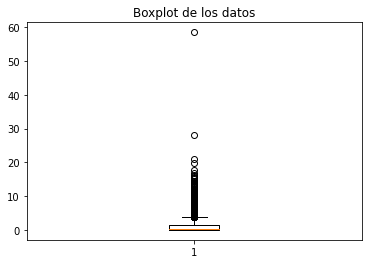

In [113]:
import matplotlib.pyplot as plt
media_reviews = datos1['reviews_per_month']
plt.boxplot(media_reviews)
plt.title("Boxplot de los datos")
plt.show()

In [114]:
from matplotlib.cbook import boxplot_stats
stats = boxplot_stats(media_reviews)
stats = stats[0]
outliers = stats['fliers']
min = stats['q1']-1.5*stats['iqr']
max = stats['q3']+1.5*stats['iqr']
print(min, max, len(outliers))

-2.27 3.89 3312


In [120]:
datos1['et_reseñas']= media_reviews.replace(np.linspace(0,max/3,1298),'BAJA')
datos1['et_reseñas']= media_reviews.replace(np.linspace(max/3,max*2/3,1298),'MEDIA')
datos1['et_reseñas']= media_reviews.replace(np.linspace(max*2/3,1000,1298),'ALTA')

datos1.head()



,id,neighbourhood_group,room_type,reviews_per_month,availability_365,et_reseñas
0,2539,Brooklyn,Private room,0.21,365,0.21
1,2595,Manhattan,Entire home/apt,0.38,355,0.38
2,3647,Manhattan,Private room,0.00,365,0.00
3,3831,Brooklyn,Entire home/apt,4.64,194,4.64
4,5022,Manhattan,Entire home/apt,0.10,0,0.10
